# Look at effect of focusing learning on where interesting dynamics occur in non-bifurcation case trajectories

That is write time-horizon scheduler to train model short time horizon until loss reaches certain threshold, or some `max-epoch` flag is reached, then increase time horizon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


from stabnode.utils import set_global_seed
from data.budworm import simulate_trials, budworm_steady_states


seed = 1234
set_global_seed(seed=seed)
device = 'cpu'

In [2]:
k = 5.34569072482332

In [3]:
xs = []
ts = []

x0s = np.linspace(0.1,10,51)
for x0 in x0s:
    budworm_trial =simulate_trials([k],x0, dt=0.1,r=0.56,eps=1e-2,buffer=0,t_max=400,n_points=501, show_progress=False)
    xs.append(budworm_trial.x_vals[0])
    ts.append(budworm_trial.t_vals[0])

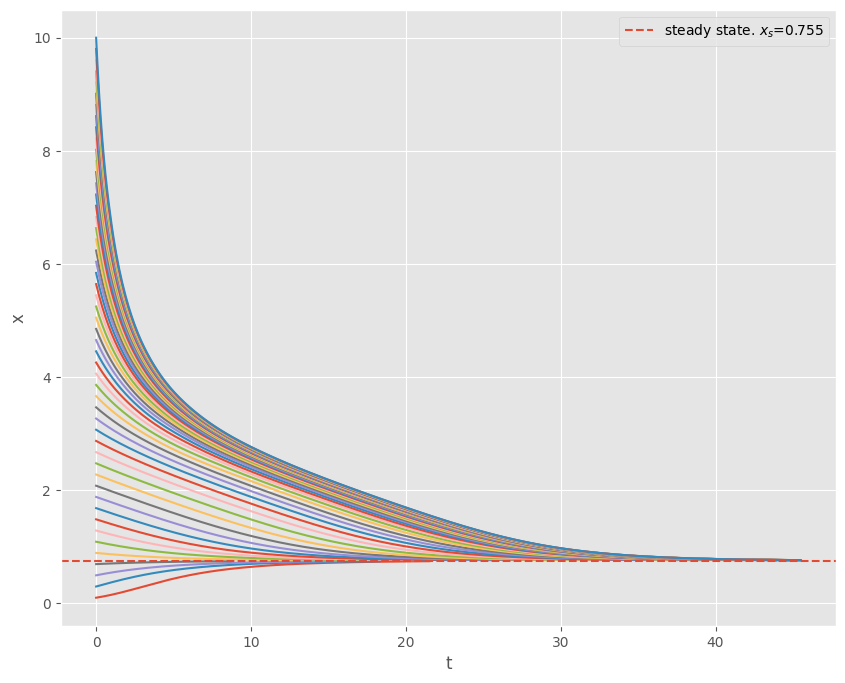

In [4]:
# expected steady states for fixed k and r
steady_states = budworm_steady_states(k,r=0.56)

plt.figure(figsize=(10,8))
for ti, xi in zip(ts, xs):
    plt.plot(ti,xi)
for x_steady_state in steady_states:
    plt.axhline(x_steady_state, linestyle='--',label=rf"steady state. $x_s$={x_steady_state:.3f}")
    # plt.show()
plt.xlabel("t")
plt.ylabel("x")
# plt.yscale('log')
plt.legend()
plt.show()

0.009336339650776848


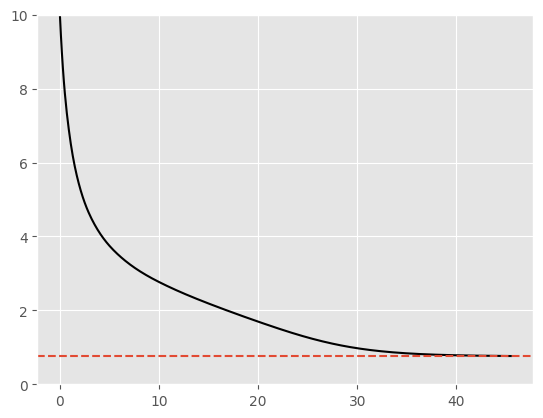

In [5]:
i = -1
plt.plot(ts[i],xs[i],c='blacK')
for x_steady_state in steady_states:
    plt.axhline(x_steady_state, linestyle='--',label=rf"steady state. $x_s$={x_steady_state:.3f}")
    print(np.abs(xs[i][-1]-x_steady_state))
plt.ylim(0,10)
plt.show()

## Standard preprocessing to scale data

In [6]:
import torch
from sklearn.preprocessing import MinMaxScaler
from stabnode.data import TrialsDataset

scaler = MinMaxScaler()
scaler.fit(np.concatenate(xs).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

xs_torch = [torch.tensor(xi,dtype=torch.float32,device=device) for xi in xs_scaled]
ts_torch = [torch.tensor(ti,dtype=torch.float32,device=device) for ti in ts]

In [7]:
ts_torch[i]

tensor([ 0.0000,  0.1000,  0.2000,  0.3000,  0.4000,  0.5000,  0.6000,  0.7000,
         0.8000,  0.9000,  1.0000,  1.1000,  1.2000,  1.3000,  1.4000,  1.5000,
         1.6000,  1.7000,  1.8000,  1.9000,  2.0000,  2.1000,  2.2000,  2.3000,
         2.4000,  2.5000,  2.6000,  2.7000,  2.8000,  2.9000,  3.0000,  3.1000,
         3.2000,  3.3000,  3.4000,  3.5000,  3.6000,  3.7000,  3.8000,  3.9000,
         4.0000,  4.1000,  4.2000,  4.3000,  4.4000,  4.5000,  4.6000,  4.7000,
         4.8000,  4.9000,  5.0000,  5.1000,  5.2000,  5.3000,  5.4000,  5.5000,
         5.6000,  5.7000,  5.8000,  5.9000,  6.0000,  6.1000,  6.2000,  6.3000,
         6.4000,  6.5000,  6.6000,  6.7000,  6.8000,  6.9000,  7.0000,  7.1000,
         7.2000,  7.3000,  7.4000,  7.5000,  7.6000,  7.7000,  7.8000,  7.9000,
         8.0000,  8.1000,  8.2000,  8.3000,  8.4000,  8.5000,  8.6000,  8.7000,
         8.8000,  8.9000,  9.0000,  9.1000,  9.2000,  9.3000,  9.4000,  9.5000,
         9.6000,  9.7000,  9.8000,  9.90

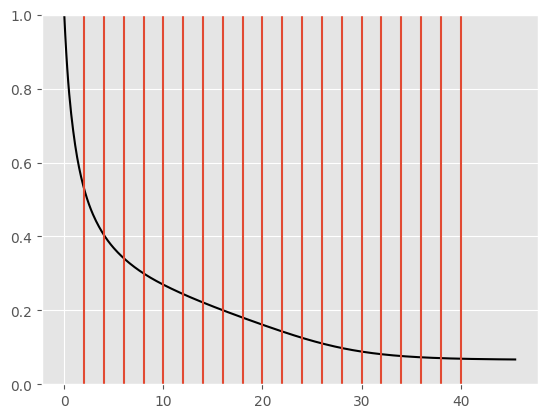

In [8]:
i = -1
start_idx = 20
idx_increase = 20
plt.plot(ts_torch[i],xs_torch[i],c='blacK')
# for x_steady_state in steady_states:
#     plt.axhline(x_steady_state, linestyle='--',label=rf"steady state. $x_s$={x_steady_state:.3f}")
#     print(np.abs(xs[i][-1]-x_steady_state))
for j in range(20):
    plt.axvline(ts_torch[i][start_idx+j*idx_increase])
plt.ylim(0,1)
plt.show()

In [9]:
2/0.1

20.0

In [10]:
train_dataset = TrialsDataset(x_trials=xs_torch, t_trials=ts_torch)

In [ ]:
# xi, ti, x0i = train_dataset[0]

In [ ]:
# xi.shape

torch.Size([216])

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=1,shuffle=False, num_workers=0)

In [ ]:
# th_idx = 100
# for out in train_loader:
#     Xi,Ti, x0i = out
#     Xi = Xi.squeeze()[:th_idx]
#     Ti = Ti.squeeze()[:th_idx]
#     x0i = x0i.reshape(-1,1)

In [ ]:
# Xi.shape

torch.Size([100])

In [ ]:
# Ti.shape

torch.Size([100])

In [ ]:
# th_idx = 10

In [ ]:
# Xi[:th_idx]

tensor([1.0000, 0.9450, 0.8970, 0.8549, 0.8179, 0.7854, 0.7566, 0.7309, 0.7076,
        0.6860])

In [19]:
class TimeHorizonScheduler:
    def __init__(self, start_idx, idx_increase, threshold, patience):
        # self.max_idx = max_idx
        self.start_idx = start_idx
        self.idx_increase = idx_increase
        self.threshold = threshold
        self.patience = patience
        self.patience_count = 0
        self.time_horizons = [start_idx]
    
    def step(self, epoch_loss):
        if np.abs(epoch_loss) <= self.threshold:
            self.patience_count += 1
        else:
            self.patience_count = 0  
        
        if self.patience_count >= self.patience:
            self.patience_count = 0
            new_idx = self.time_horizons[-1] + self.idx_increase
        else:
            new_idx = self.time_horizons[-1]
        
        self.time_horizons.append(new_idx)
    
    def get_time_horizon(self):
        return self.time_horizons[-1]


In [20]:
# sched = TimeHorizonScheduler( start_idx=5, idx_increase=5, threshold=0.1, patience=3)

# for epoch_loss in [0.5, 0.05, 0.02, 0.01, 1,0.3, 0.05, 0.04, 0.03, 0.01]:
#     sched.step(epoch_loss)
#     print(f"Loss={epoch_loss}, Horizon={sched.get_time_horizon()}")


In [21]:
# train_loader

## create model and train with lr and time horizon schedulers

In [22]:
import torch.nn as nn
from stabnode.node import GeluSigmoid, FeluSigmoid, StabNODE, model_trainer

In [23]:
# create new classes for constant f and g

f = FeluSigmoid(
    dim_in=1,
    dim_out=1,
    hidden_dim=6,
    lower_bound=-0.5,
    upper_bound=-0.1
)

g = GeluSigmoid(
    dim_in=1+1, # input is x dim + k dim
    dim_out=1,
    hidden_dim=6,
    lower_bound=-5,
    upper_bound=1.1  
)

model = StabNODE(f,g).to(device)

In [24]:
n_epochs = 50
lr = 1e-3
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.1,patience=10)
th_sched = TimeHorizonScheduler(start_idx=20, idx_increase=20,threshold=1e-2,patience=2)

model, log_history = model_trainer(
    model=model,
    opt=opt,
    loss_criteria=loss_criteria,
    train_loader=train_loader,
    n_epochs=n_epochs,
    control=lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0),
    min_improvement=1e-6,
    patience=30,
    solve_method='tsit5',
    save_folder=None,
    show_progress=True,
    scheduler=scheduler,
    time_horizon_scheduler=th_sched,
    print_every=1,
    effective_batch_size=10,
    _precision=7,
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: Loss: 2.5864228. time = 4.3009269s. lr = 0.0010000. time_horizon=20
Epoch 1: Loss: 2.1699197. time = 4.3570602s. lr = 0.0010000. time_horizon=20
Epoch 2: Loss: 1.8073545. time = 4.5049191s. lr = 0.0010000. time_horizon=20
Epoch 3: Loss: 1.4960679. time = 4.3377781s. lr = 0.0010000. time_horizon=20
Epoch 4: Loss: 1.2332726. time = 4.3448989s. lr = 0.0010000. time_horizon=20
Epoch 5: Loss: 1.0145318. time = 4.3372800s. lr = 0.0010000. time_horizon=20
Epoch 6: Loss: 0.8344215. time = 4.1582441s. lr = 0.0010000. time_horizon=20
Epoch 7: Loss: 0.6872331. time = 4.2487941s. lr = 0.0010000. time_horizon=20
Epoch 8: Loss: 0.5674995. time = 4.1220772s. lr = 0.0010000. time_horizon=20
Epoch 9: Loss: 0.4703057. time = 4.1722491s. lr = 0.0010000. time_horizon=20
Epoch 10: Loss: 0.3914224. time = 4.1472771s. lr = 0.0010000. time_horizon=20
Epoch 11: Loss: 0.3273168. time = 4.2737648s. lr = 0.0010000. time_horizon=20
Epoch 12: Loss: 0.2750994. time = 4.0910711s. lr = 0.0010000. time_horizon

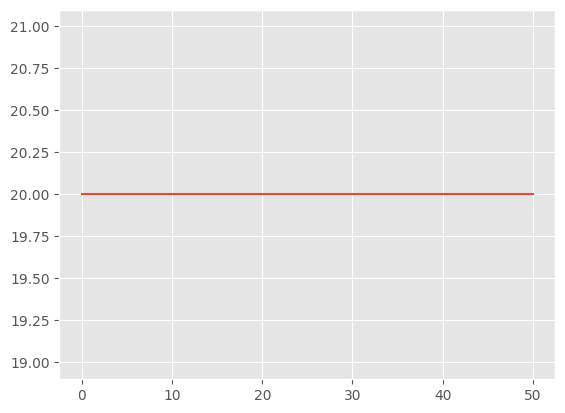

In [25]:
plt.plot(th_sched.time_horizons)

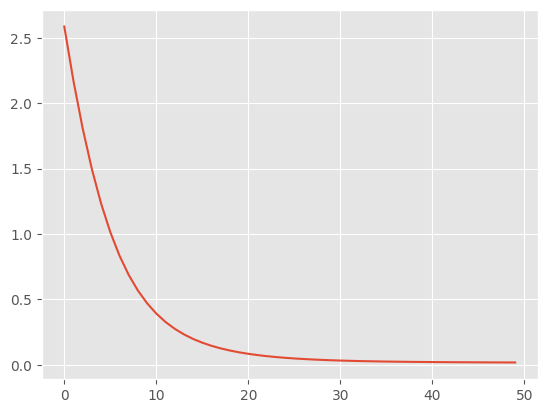

In [26]:
plt.plot(log_history["losses"])